Part 1: Prompt engineering

In [ ]:
!pip install google-generativeai

In [ ]:
#we will be exploring google's python wrapper around their ai API
import os
import google.generativeai as genai

#generate your own key on https://aistudio.google.com/apikey
gemini_api_key ="-"

genai.configure(api_key=gemini_api_key)
multimodal_model = genai.GenerativeModel("gemini-1.5-flash-002")


In [ ]:
#recall that text prompting and image prompting are both supported
model_response = multimodal_model.generate_content("hi, how was your day?")
model_response.text

'As a large language model, I don\'t experience days in the same way humans do. I don\'t have feelings or personal experiences.  However, I\'ve been busy processing information and responding to many user requests.  So, in a sense, it\'s been a productive "day" for me. How was yours?\n'

In [ ]:
from PIL import Image

img = Image.open("harrypotter.webp")
model_response = multimodal_model.generate_content(["how many male and female actors are in this image? return as list of two numbers: ", img])
model_response.text

'[2, 1]'

In [ ]:
!pip install numpy

In [ ]:
import numpy as np
import pandas as pd

print("NumPy version:", np.__version__)

NumPy version: 1.24.4


In [ ]:
#using your BERT sentiment analysis code from project 3, repeat the process with the uiuc dataset

# Label the dataset (if needed, for downstream tasks)
uiuc = pd.read_csv("uiuc.csv")
uiuc["label"] = 1

# Load sentiment pipeline


# Import pipeline after ensuring NumPy is available
from transformers import pipeline


pipe = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-sentiment",  # Trained on tweets
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment",
    return_all_scores=False
)
sampled = uiuc.sample(n=500, random_state=42)
texts = sampled['text'].astype(str).apply(lambda x: x[:512]).tolist()

results = pipe(texts)  # No batch_size here!

sampled['sentiment'] = [res['label'] for res in results]
print(sampled['sentiment'].value_counts())


Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

sentiment
LABEL_1    247
LABEL_0    127
LABEL_2    126
Name: count, dtype: int64


Label 0 negative Label 1 neutral label 2 positive

In [ ]:
bert_results = [pipe(post[:512])[0]['label'] for post in sampled_posts]

In [ ]:
from collections import Counter

# Count BERT results
bert_counts = sampled['sentiment'].value_counts()
bert_total = len(sampled)

# Calculate percentages
bert_percentages = {label: round(count / bert_total * 100, 1) for label, count in bert_counts.items()}

# Print summary
print("BERT Sentiment Counts:", bert_counts.to_dict())
print("BERT Sentiment Percentages:", bert_percentages)

BERT Sentiment Counts: {'LABEL_1': 247, 'LABEL_0': 127, 'LABEL_2': 126}
BERT Sentiment Percentages: {'LABEL_1': 49.4, 'LABEL_0': 25.4, 'LABEL_2': 25.2}


In [ ]:
#using the Gemini API, write a prompt to generate sentiment analysis on the same dataset
gemini_prompt = """
You are a sentiment analysis assistant.

Given a list of social media posts, classify the sentiment of each post as one of only the following three categories:
- Positive
- Negative
- Neutral

Return the results in a Python-style list of sentiment labels. For example:
["Positive", "Neutral", "Negative", ...]

Here are the posts:
"""
#make sure to includein the prompt a limit to the type of results (positive, negative, neutral)
sampled_posts = uiuc['text'].astype(str).sample(25, random_state=42).tolist()
input_text = gemini_prompt + "\n" + "\n".join(sampled_posts)
response = multimodal_model.generate_content(input_text)
gemini_output = response.text
gemini_output

'```python\nsentiment_labels = [\n    "Negative",\n    "Negative",\n    "Positive",\n    "Neutral",\n    "Positive",\n    "Neutral",\n    "Negative",\n    "Positive",\n    "Neutral",\n    "Negative",\n    "Positive",\n    "Neutral",\n    "Neutral",\n    "Negative",\n    "Positive",\n    "Neutral",\n    "Neutral",\n    "Negative",\n    "Negative",\n    "Neutral",\n    "Neutral",\n    "Negative",\n    "Neutral",\n    "Neutral",\n    "Neutral"\n]\n```\n'

In [ ]:
import re

# Clean Gemini response text
raw = gemini_output

# Extract only the labels using regex (or basic split if it’s a plain list of strings)
gemini_results = re.findall(r'"(Positive|Negative|Neutral)"', raw)


from collections import Counter

gemini_counts = Counter(gemini_results)
gemini_percentages = {k: round(v / len(gemini_results) * 100, 1) for k, v in gemini_counts.items()}

print("Gemini Sentiment Counts:", gemini_counts)
print("Gemini Sentiment Percentages:", gemini_percentages)


Gemini Sentiment Counts: Counter({'Neutral': 12, 'Negative': 8, 'Positive': 5})
Gemini Sentiment Percentages: {'Negative': 32.0, 'Positive': 20.0, 'Neutral': 48.0}


In [ ]:
# Map BERT labels to sentiment categories
label_map = {
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive'
}

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Post': sampled_posts,
    'BERT Sentiment': bert_results,
    'Gemini Sentiment': gemini_results
})

# Apply the mapping to the BERT sentiment column
comparison_df['BERT Sentiment'] = comparison_df['BERT Sentiment'].map(label_map)

# Display the comparison DataFrame
comparison_df


,Post,BERT Sentiment,Gemini Sentiment
0,"they wear neon green polos and lanyards, if yo...",Negative,Negative
1,true i agree,Positive,Negative
2,"Last year, I was really introverted and didn't...",Positive,Positive
3,Gonna throw my hat into the ring here because ...,Neutral,Neutral
4,Thank you so much!,Positive,Positive
5,My electricity bill last month for my 1BD was ...,Negative,Neutral
6,You should not take any chances and go see a d...,Negative,Negative
7,"Unrelated to carpooling, but typically if you ...",Positive,Positive
8,Someone got a good score at their SAT/GRE vocab.,Positive,Neutral
9,One that may make you lose your lunch from the...,Negative,Negative


In [ ]:
#find a few cases where their judgement differs
diff_df = comparison_df[comparison_df['BERT Sentiment'] != comparison_df['Gemini Sentiment']]
diff_df

,Post,BERT Sentiment,Gemini Sentiment
1,true i agree,Positive,Negative
5,My electricity bill last month for my 1BD was ...,Negative,Neutral
8,Someone got a good score at their SAT/GRE vocab.,Positive,Neutral
11,Real: sometimes they give out dilly bars in th...,Positive,Neutral
13,"Yeah, like you know what dial-up is...",Neutral,Negative
14,"Hey, just a throwaway because I don't like usi...",Neutral,Positive
18,consider the user name and numbre of posts....,Neutral,Negative
19,"You all don’t realize, he has not received eno...",Negative,Neutral
20,Bad bot,Negative,Neutral
21,There's no such thing as heat lightning. Just...,Neutral,Negative


In [ ]:
pd.set_option('display.max_colwidth', None)  # show full string content in all columns

# Then display the full posts
diff_df[['Post', 'BERT Sentiment', 'Gemini Sentiment']]

,Post,BERT Sentiment,Gemini Sentiment
1,true i agree,Positive,Negative
5,"My electricity bill last month for my 1BD was $129, so $129 - $40 = $89. I'd say most electricity bills range from $100 - $150. \n\nAlso, electricity prices fluctuate based on consumption and time of day. So during peak hours you're paying way more. So if you're trying to cut costs, watch your consumption during that time.",Negative,Neutral
8,Someone got a good score at their SAT/GRE vocab.,Positive,Neutral
11,"Real: sometimes they give out dilly bars in the basement, usually around finals \n\nExtra real: open 24/7, third door on the right after going down the elevator. Can't miss it, the light's been out on the sign ever since they started restoring the building but they're still open",Positive,Neutral
13,"Yeah, like you know what dial-up is...",Neutral,Negative
14,"Hey, just a throwaway because I don't like using my real account with local things, but I know about James Carr the owner. His business name isn't his own name though so you won't find that, but he has a cleaning company that cleans for University group. I'm very aware all the student housing groups are there to rip off students, but wanted to at least give you a heads up that I can promise that James Carr is a real cleaning company owner. I have no idea about the other company though.",Neutral,Positive
18,consider the user name and numbre of posts....,Neutral,Negative
19,"You all don’t realize, he has not received enough money to get back. He needs to collect more",Negative,Neutral
20,Bad bot,Negative,Neutral
21,There's no such thing as heat lightning. Just a storm in the distance.,Neutral,Negative


#compare the sentiment percentages, what do you notice? Does one method overestimate or underestimate the sentiment of the dataset?
#find a few cases where their judgement differs, what do you think is the reason for the discrepancy? And which answer do you find more convincing?

1. Both models has high proportion of Neutral sentiment. 
2. Bert gives a more balanced distribution between Negative and positive while Gemini has higher percentage towards Negative sentiment. 
3. Gemini overestimate negativity slightly and underestimate positivity. 

- Bert is more optimistic or neutral. For example phrases like "good score", "i agree" were treated as positive where Gemini thought it as neutral. 
-Gemini is more good at marking emotionally ambigious and factual posts as Neutral. 
I think Bert is sensitive to how each words or phrases sounding positive or negative. Where as Gemini is able to capture context of the whole text and classify as Factual/Neutral. I find Gemeini more convincing because even though a word may sound positive/negative alone, based on context it may carry a different sentiment.

Part 2: images

In [ ]:
from PIL import Image

In [ ]:
#download 10 images from the internet with a feature you're interested in studying. e.g. gender, race, age, action, etc.

#ask the model to annotate the images with the features you're interested in studying

#choose 2 objective (clear right or wrong answer) questions and ask the model to answer them, like how many people are in the image, or what is the color of the object in the image

#choose 2 subjective (open to interpretation) questions and ask the model to answer them, like what is the mood of the person in the image or what race/gender is the person

#look through the responses. Is there anything you disagree with? What do you think is the reason for the discrepancy? Would you trust large scale results generated for this annotation? b

In [ ]:
# Define features to annotate
annotation_prompt = """
I am studying the following features:
- How many people are in the image?
- What is the main color of the person’s shirt?

Also answer these subjective questions:
- What emotion is the person showing?
- What race do you think the person presents as?

Respond in this format:
{
  "people_count": ...,
  "shirt_color": "...",
  "emotion": "...",
  "race": "..."
}
"""

folder = "study_images"
results = {}

for filename in os.listdir(folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        path = os.path.join(folder, filename)
        image = Image.open(path)

        try:
            response = multimodal_model .generate_content([annotation_prompt, image])
            results[filename] = response.text
        except Exception as e:
            print(f"Error on {filename}: {e}")
            results[filename] = "Error"

In [ ]:
# Print results
for filename, result in results.items():
    print(f"Results for {filename}:")
    print(result)
    print("\n" + "="*50 + "\n")

Results for s_BF38E266280C4332A29ED0AE9DACD0C37D30AAA3B2E109CFE8C8F22096A0F00F_1721013224644_AP24195803307155.jpg:
```json
{
  "people_count": 4,
  "shirt_color": "white",
  "emotion": "anger",
  "race": "white"
}
```


Results for Eminem-and-Barack-Obama-102224-ba4fa65b498e4c209e307d514fd56cc7.jpg:
```json
{
  "people_count": 2,
  "shirt_color": "white",
  "emotion": "engaged in conversation",
  "race": "Black and White"
}
```


Results for 3urv4x.jpg:
```json
{
  "people_count": 1,
  "shirt_color": "white",
  "emotion": "suspicious",
  "race": "cartoon"
}
```


Results for a-background-of-human-artificial-intelligence-generated-by-ai-free-photo.jpg:
```json
{
  "people_count": 1,
  "shirt_color": "The image depicts a cyborg, not a person wearing clothes, so there is no shirt color.",
  "emotion": "Stoic, perhaps slightly pensive or melancholic.",
  "race": "It's impossible to determine race as it is a cyborg, not a human."
}
```



Results for sub-buzz-1138-1548268729-1.jpg:
```json


#look through the responses. Is there anything you disagree with? What do you think is the reason for the discrepancy? Would you trust large scale results generated for this annotation? 

I disagree with the emotion for the black person in picture "f119.." as "thoughtful." The person smiling and giving off some little mocking "yall gotta use your brain" type of vibe. I think his hand pointing to his head made gemini think he is actually "thinking" thus thoughtful. However, I would trust most large scale results because for other photos gemini showed high accuracy. 

Part 3: Network Demo

In [ ]:
!pip install networkx

In [ ]:
import networkx as nx

In [ ]:
#new graph
G = nx.Graph()

In [ ]:
G.add_node(1)
G.add_nodes_from([2, 3])
#can add additional attributes to the nodes
G.add_nodes_from([(4, {"color": "red"}), (5, {"color": "green"})])

In [ ]:
G.nodes[4]

{'color': 'red'}

In [ ]:
list(G.nodes)

[1, 2, 3, 4, 5]

In [ ]:
# can manually add edges too
G.add_edge(1, 2)


In [ ]:
G.number_of_edges() 

1

In [ ]:
#load edges from csv
import pandas as pd

edges = pd.read_csv("got-edges.csv")

G = nx.from_pandas_edgelist(edges, 'Source', 'Target')

In [ ]:
G.number_of_edges()

352

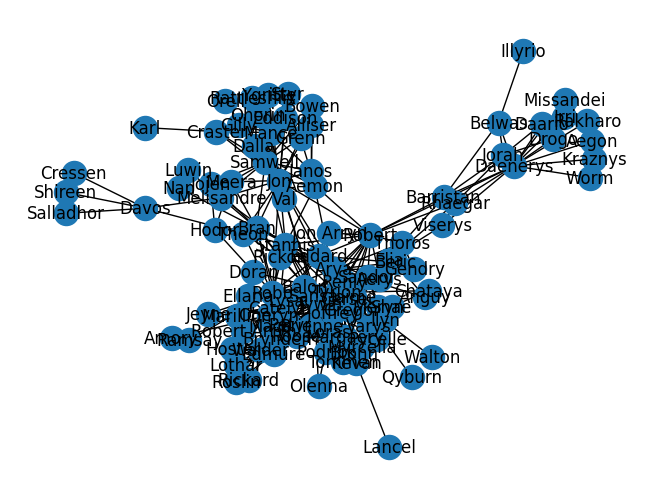

In [ ]:
#visualize the graph

import matplotlib.pyplot as plt

nx.draw(G, with_labels=True)

plt.show()




In [ ]:
#calculate the density of the graph

nx.density(G)


0.062070181625815554

In [ ]:
#return highest degree nodes

sorted(G.degree, key=lambda x: x[1], reverse=True)

[('Tyrion', 36),
 ('Jon', 26),
 ('Sansa', 26),
 ('Robb', 25),
 ('Jaime', 24),
 ('Tywin', 22),
 ('Cersei', 20),
 ('Arya', 19),
 ('Robert', 18),
 ('Joffrey', 18),
 ('Catelyn', 18),
 ('Samwell', 15),
 ('Bran', 14),
 ('Stannis', 14),
 ('Daenerys', 14),
 ('Sandor', 13),
 ('Mance', 12),
 ('Gregor', 12),
 ('Eddard', 12),
 ('Lysa', 10),
 ('Loras', 9),
 ('Brynden', 8),
 ('Walder', 8),
 ('Edmure', 8),
 ('Renly', 8),
 ('Oberyn', 7),
 ('Brienne', 7),
 ('Petyr', 7),
 ('Meryn', 7),
 ('Varys', 7),
 ('Margaery', 7),
 ('Beric', 6),
 ('Rickon', 6),
 ('Balon', 6),
 ('Barristan', 6),
 ('Ilyn', 6),
 ('Jorah', 6),
 ('Rhaegar', 6),
 ('Janos', 6),
 ('Kevan', 6),
 ('Aemon', 5),
 ('Thoros', 5),
 ('Meera', 5),
 ('Podrick', 5),
 ('Lothar', 5),
 ('Elia', 5),
 ('Shae', 5),
 ('Craster', 5),
 ('Davos', 5),
 ('Tommen', 5),
 ('Qhorin', 5),
 ('Grenn', 4),
 ('Aerys', 4),
 ('Gendry', 4),
 ('Roose', 4),
 ('Belwas', 4),
 ('Hodor', 4),
 ('Jojen', 4),
 ('Theon', 4),
 ('Bronn', 4),
 ('Roslin', 4),
 ('Pycelle', 4),
 ('Daario', 

In [ ]:

#make dataframes with nodes and a column for each centrality measure
df=pd.DataFrame(list(nx.degree_centrality(G).items()), columns=['node', 'degree'])
#add column for betweeness centrality
df['betweenness'] = list(nx.betweenness_centrality(G).values())
#add column for closeness centrality
df['closeness'] = list(nx.closeness_centrality(G).values())
#add column for eigenvector centrality
df['eigenvector'] = list(nx.eigenvector_centrality(G).values())
df




,node,degree,betweenness,closeness,eigenvector
0,Aemon,0.047170,0.004623,0.389706,0.044139
1,Grenn,0.037736,0.000060,0.330218,0.019480
2,Samwell,0.141509,0.032273,0.384058,0.054346
3,Aerys,0.037736,0.000000,0.392593,0.078330
4,Jaime,0.226415,0.099943,0.479638,0.273663
...,...,...,...,...,...
102,Ramsay,0.009434,0.000000,0.329193,0.018535
103,Chataya,0.018868,0.000000,0.340836,0.031102
104,Shireen,0.009434,0.000000,0.250000,0.001142
105,Doran,0.009434,0.000000,0.339744,0.025483


3a. explore this dataframe, are there huge differences between these types of centrality? What might cause this?

Yes there are noticeable differences between all columns. Names in the dense central cluster might be represented through high degree centrality while names on the outside might have low degree centrality. Betweenness centrality reflect how often a node acts as a bridge between different parts. Thus, names with high betweenness may not have the most direct connection, but position themselves between subgroups in the graph where names with low betweenness might be in dense central clusters. Closeness centrality capture how easily node can reach all others. Nodes in center would have higher closeness compared to nodes on the outside edge. Eigenvector represent being connected to other important nodes. This would just depend on the nodes around each node. 

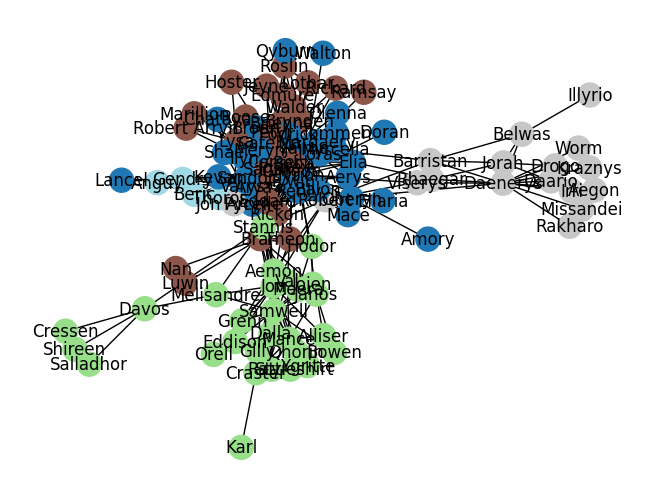

In [ ]:
#calculate community structure
import networkx.algorithms.community as nxcom
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)

#add community to node features

for i, community in enumerate(communities):
    for node in community:
        df.loc[df.node == node, "community"] = i

#color nodes by community
colors = df.community / df.community.max()

nx.draw(G, with_labels=True, node_color=colors, cmap=plt.cm.tab20)

plt.show()


Part 4: make your own social network. Take either a short excerpt of a novel, tv show, movie, or real life social network you are familiar with. Make a csv modelled off of the got-edges.csv with a Source, Target, and weight column. You need to decide what constitutes an edge and node, but easiest is characters or people connected by their number of interactions. You should manually type this into the csv. Include at least 25 edges

What kind of potential issues did you run into while converting it into a graph? Any ambiguities that made it difficult to decide? 

use either Gephi or NetworkX to calculate node centrality and community features and add a visualization of the graph here. Does it align with your understanding of the media? 

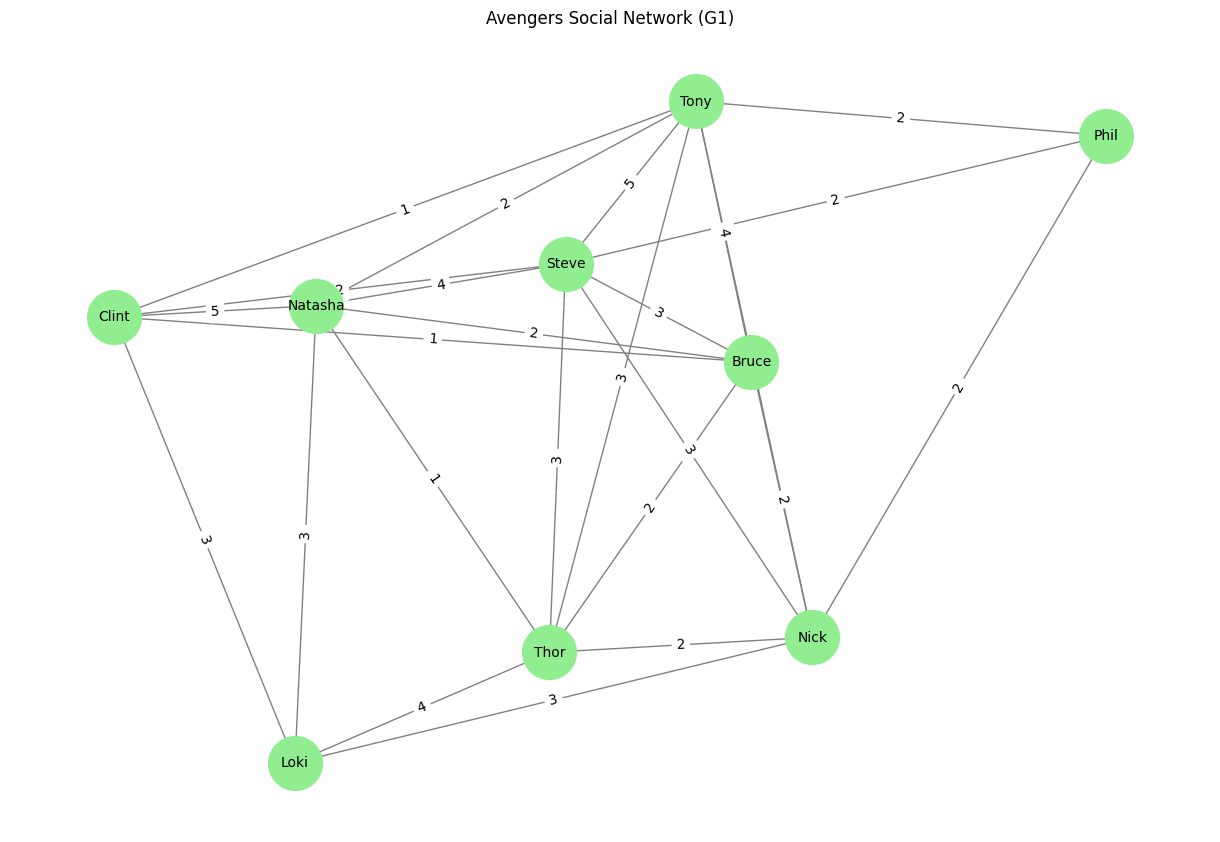

In [ ]:
edges_df = pd.read_csv("social.csv")

G1 = nx.Graph()

for _, row in edges_df.iterrows():
    G1.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# 4. Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G1, seed=42)
nx.draw(G1, pos, with_labels=True, node_size=1500, node_color="lightgreen", edge_color="gray", font_size=10)

# 5. Add edge labels (weights)
edge_labels = nx.get_edge_attributes(G1, 'weight')
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels)

plt.title("Avengers Social Network (G1)")
plt.show()

In [ ]:
# Degree Centrality
deg_cent = nx.degree_centrality(G1)
print("Top Degree Centrality:")
print(sorted(deg_cent.items(), key=lambda x: -x[1])[:5])

# Betweenness Centrality
btw_cent = nx.betweenness_centrality(G1)
print("\nTop Betweenness Centrality:")
print(sorted(btw_cent.items(), key=lambda x: -x[1])[:5])

# Closeness & Eigenvector (optional)
clo_cent = nx.closeness_centrality(G1)
eig_cent = nx.eigenvector_centrality(G1)

# Closeness Centrality
print("\nTop Closeness Centrality:")
print(sorted(clo_cent.items(), key=lambda x: -x[1])[:5])

# Eigenvector Centrality
print("\nTop Eigenvector Centrality:")
print(sorted(eig_cent.items(), key=lambda x: -x[1])[:5])

Top Degree Centrality:
[('Tony', 0.875), ('Steve', 0.875), ('Bruce', 0.75), ('Thor', 0.75), ('Nick', 0.75)]

Top Betweenness Centrality:
[('Nick', 0.0863095238095238), ('Tony', 0.08273809523809522), ('Steve', 0.08273809523809522), ('Thor', 0.033928571428571426), ('Natasha', 0.033928571428571426)]

Top Closeness Centrality:
[('Tony', 0.8888888888888888), ('Steve', 0.8888888888888888), ('Bruce', 0.8), ('Thor', 0.8), ('Nick', 0.8)]

Top Eigenvector Centrality:
[('Tony', 0.3973108480575807), ('Steve', 0.3973108480575807), ('Bruce', 0.3687675782635233), ('Thor', 0.35864939936809037), ('Natasha', 0.35361031471631765)]


In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

# Calculate communities (clusters)
communities = list(greedy_modularity_communities(G1))

# Print the number of clusters and their members
print(f"🔍 Detected {len(communities)} clusters:")
for i, community in enumerate(communities):
    print(f"Cluster {i+1}: {sorted(community)}")

🔍 Detected 2 clusters:
Cluster 1: ['Bruce', 'Nick', 'Phil', 'Steve', 'Thor', 'Tony']
Cluster 2: ['Clint', 'Loki', 'Natasha']


What kind of potential issues did you run into while converting it into a graph? Any ambiguities that made it difficult to decide? 

use either Gephi or NetworkX to calculate node centrality and community features and add a visualization of the graph here. Does it align with your understanding of the media? 

- I wasn't able to find a way to record every single interaction between the charactors in the movie without pouring hours into it. Thus, I used my expertise in Marvel charactors to set weights based on how close, how often they were togather, and emotionally connected the characters are in the movie. 
- I agree with cluster 1 because they are the main charactors that had numerous meaningful conversations in the movie. Cluster 2 does encompass the romantic relationship between Clint and Natasha. Clint and Loki did had a moment where they were fighting togather in a movie because Loki used his powers. 
- The centrality strongly represent my understanding of Avengers Universe. The high Degree Centrality between Tony and Steve make sense because they were the clear leaders in the squad. Nick shows high betweenness centrality because he bridges connections between the Avengers and agents from SHIELD. Tony and Steve also show high closeness and betweenness since they are strong communication bridges between other members. 
- The visualization shows Tony and Steve as core of the network. This matches their high degree, closeness cetrality. Nick the head of shield also seems to connect many nodes togather. Clint, Loki, Natasha are close togather on the side of the graphw which  alligns to Cluster 2. 